# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [0]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 53.6MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x56624000 @  0x7f72a15eb2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 1.2MB/s 
    100% |████████████████████████████████| 2.0MB 5.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: True


In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'  'Team Drives'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'harry_potter/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'harry_potter.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
import pt_util
os.chdir('/content')

/content
sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
sys.path.append(BASE_PATH)
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
import re
import math
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub('\s+', ' ', data).strip()

    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    count = 0
    list_indexed = []
    for char in data:
        if char not in voc2ind.keys():
            voc2ind[char] = count
            count += 1
        list_indexed.append(voc2ind[char])
        #pass # TODO Fill this in
    print (len(voc2ind.keys()))
    
    ind2voc = {val: key for key, val in voc2ind.items()}
    
    data_indexed = np.array(list_indexed)
    list_indexed = []
    print (data_indexed.shape)
    print (data_indexed.shape[0])
    
    split_index = math.ceil((4 * data_indexed.shape[0]) / 5)
    print (split_index)
    train_text = data_indexed[:split_index] 
    # TODO Fill this in
    test_text = data_indexed[split_index:]
    # TODO Fill this in
    
    print (train_text.shape, test_text.shape)
    
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
    return voc2ind
    
voc2ind = prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

89
(6227357,)
6227357
4981886
(4981886,) (1245471,)


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        num = dataset['tokens'].shape[0] - (dataset['tokens'].shape[0] % batch_size)
        self.dataset = dataset['tokens'][:num]
        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        chunk_size = math.floor(self.dataset.shape[0] / self.batch_size)
        num_examples_batch = math.floor(chunk_size / self.sequence_length)
        length = self.batch_size * num_examples_batch 
        return length
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_size = math.floor(self.dataset.shape[0] / self.batch_size)
        within_chunk, chunk_idx = divmod(idx, self.batch_size)
        new_idx = chunk_idx * chunk_size + within_chunk * self.sequence_length
        last_idx = new_idx + self.sequence_length - 1
        data = self.dataset[new_idx:last_idx+2]
        data = torch.LongTensor(data)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        x = x.view(-1,1)
        x = self.encoder(x)
        x = x.view(batch_size, sequence_length, self.feature_size)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
BEAM_WIDTH = 20


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, temperature=1)

        outputs = []
        # Initializes the beam list
        beam = [([], output, hidden, 0)]
        for ii in range(sequence_length):
            if sampling_strategy == 'max':
                # TODO max sampling strategy
                # raise NotImplementedError
                _, pred_label = torch.max(output, 1)
                outputs.append(pred_label)
                new_input = pred_label.unsqueeze(1)
                output, hidden = model.inference(new_input, hidden, temperature=1)
                

            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                # raise NotImplementedError 
                pred_label = torch.multinomial(output, 1, True)
                outputs.append(pred_label)
                new_input = pred_label.unsqueeze(1)
                output, hidden = model.inference(new_input, hidden, temperature=1)
                

            elif sampling_strategy == 'beam':
                # Todo: beam search sampling strategy
                # raise NotImplementedError
                new_beam = []
                for be in beam:
                    pred_label = torch.multinomial(be[1], 2, True)
                    for p in pred_label[0]:
                        out1, hid1 = model.inference(p, be[2], temperature=1)
                        new_beam.append((be[0]+[p], out1, hid1, be[3]+np.log(be[1][0][p].item())))
                new_beam = sorted(new_beam, key=lambda x: x[3], reverse=True)[:beam_width]
                beam = new_beam
        
        if sampling_strategy == 'beam':
            outputs = beam[0][0]
        
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    print ("enumerate train  ", len(train_loader))
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        print ("enumerate test   ", len(test_loader))
        for batch_idx, (data, label) in enumerate(test_loader):
            
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    train_loader.dataset.vocab.array_to_words(data[0]),
                    train_loader.dataset.vocab.array_to_words(label[0]),
                    train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [0]:
SEQUENCE_LENGTH = 128
BATCH_SIZE = 128
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs_1115/log.pkl'

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_1115')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_1115/%03d.pt' % epoch)
        seed_words = 'Harry Potter'
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints_1115/%03d.pt' % epoch, 0)


Using device cuda
num workers: 2
enumerate test    76
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry at once, anxious about Du
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harry at once, anxious about Dum
pred	//ouuuuggPPPIInmmguuungCIuuu6TD/\IgouTfu{{ougggmmmmmW/00vIZ'ttmmZZguunn/mmm66m/\ggguu??uuummguun\vTuuuuuuu?m{????{mu6P6RDuuPP/DD


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore, his voice a little stronge
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore, his voice a little stronger
pred	mmmmmmDWuDmZBTuuuuu\DDDggPD(uuI///mmmmDDDmZ/\ggguummmmmmmmmmmmW/m?b//ggguugn\.?uuuuumgQun\\\n//ggggg??I\;P;PPPPuuuuu///ggggggmOg


Input	parition had thrown Dumbledore off-balance; then he saw his face, paler and damper than ever in the distant light of a streetlam
GT	ar

#Part 7: Experiments

In [0]:
seed_words = 'Harry Potter and the'
sequence_length = 200

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

generated with max	 Harry Potter and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and started to the stairs and the stairs and the stairs and started to the stairs and t
generated with sample	 Harry Potter and their side of Falicable was a longed cabiling stuckbing into attempt through Lunable time. Theres that he was nobody hat even his face. So but he finding up whather she lained and Clackward suboophed in 
generated with sample	 Harry Potter and the two unless, listening Ron to these up. LWASTND That this praces that turning he who loosed to be to the doors all termit. Hermione did, they because ill all a roar wizard that was lit unless they all
generated with sample	 Harry Potter and they woaded. Harry stood whiteling the wards on one holding elbown last, which last remove. So Ron'lawn drapq and throw themrely shaped his wacatchesing benwards as it from Balles rattled there was a lat
generated with sample	 Harr

[list([(0, 2.615988279643812), (1, 1.5152361526301033), (2, 1.4219527887670618), (3, 1.3788129648095684), (4, 1.3566722113050913), (5, 1.342142729382766), (6, 1.330516828126029), (7, 1.3206347678052752), (8, 1.3120185136795044), (9, 1.304102910584525), (10, 1.2973165104263706), (11, 1.2909399129842456), (12, 1.2851747270477445), (13, 1.2797909308420985), (14, 1.2751298907556032), (15, 1.2707312071793957), (16, 1.2665702316321825), (17, 1.2625984682848579), (18, 1.2589899289764857), (19, 1.2555979521651017), (20, 1.2525743399011462)])
 list([(0, 9.031247440137362), (0, 1.6189051333226656), (1, 1.4924566981039549), (2, 1.4323740225089223), (3, 1.40219341453753), (4, 1.395591770347796), (5, 1.3772209616083848), (6, 1.369945930807214), (7, 1.3563079488904852), (8, 1.3514400171606165), (9, 1.3431635404887952), (10, 1.3389234919297068), (11, 1.3363063758925389), (12, 1.333340894234808), (13, 1.3274213389346474), (14, 1.3240468878495066), (15, 1.321656589445315), (16, 1.3188134698491347), (17

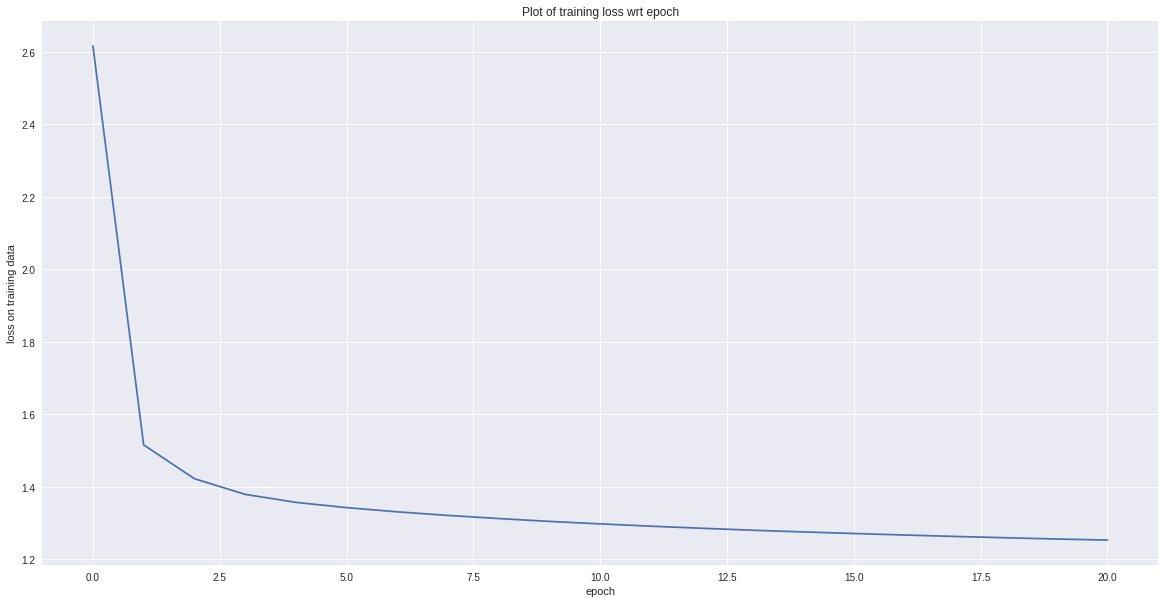

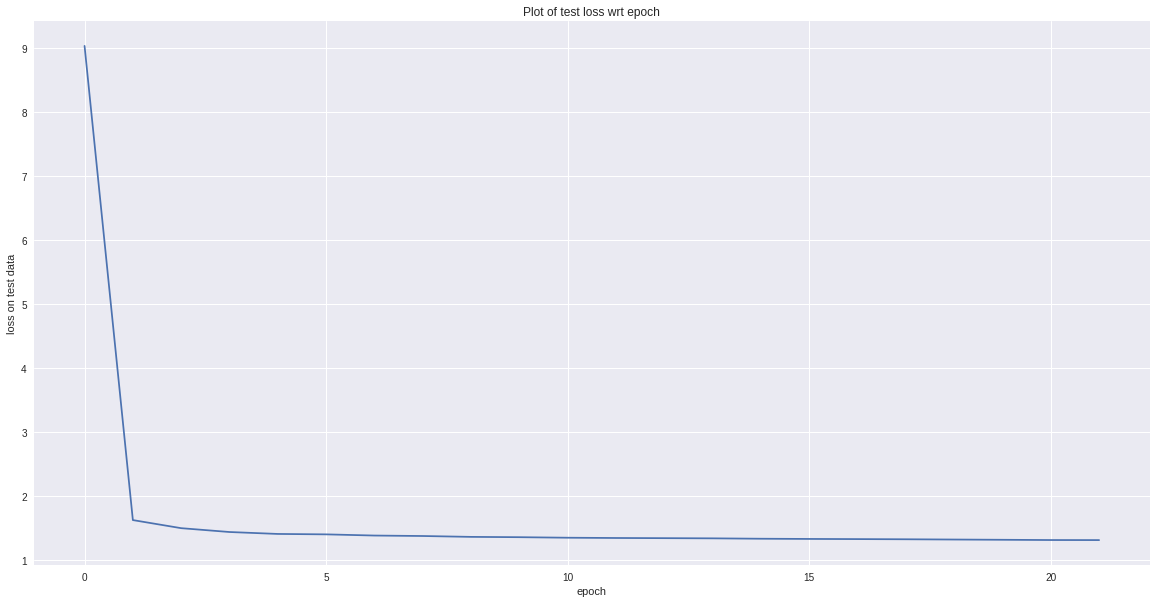

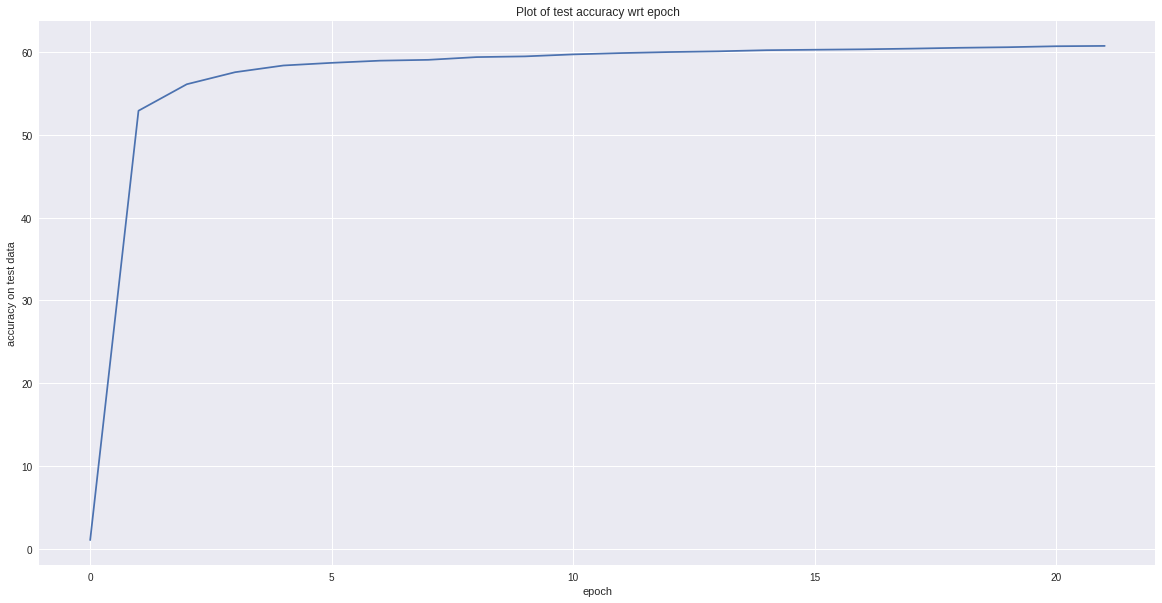

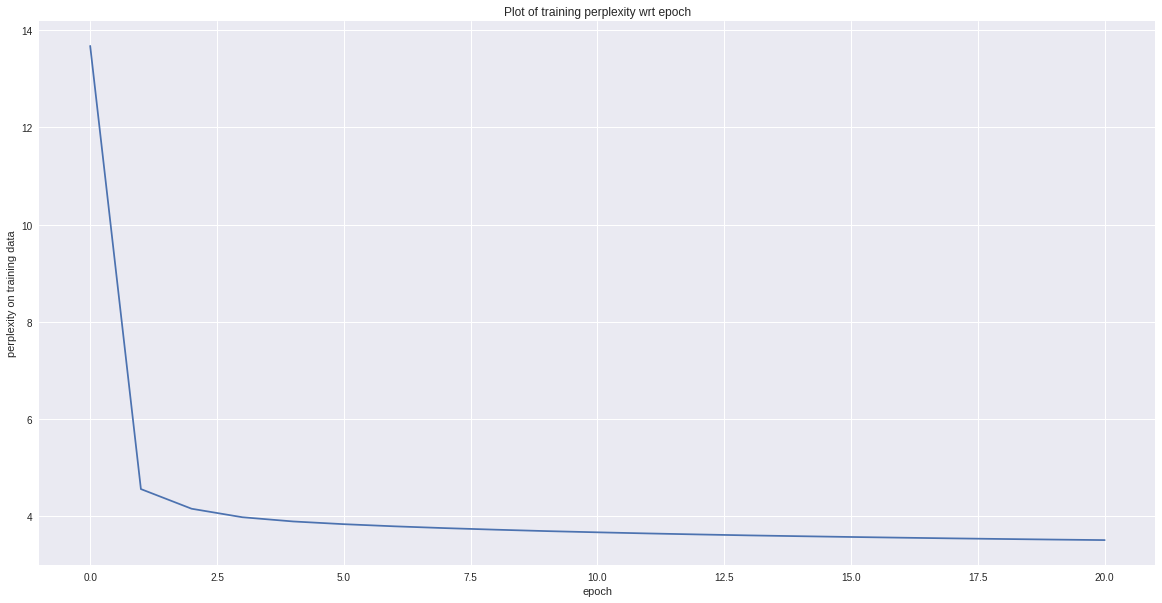

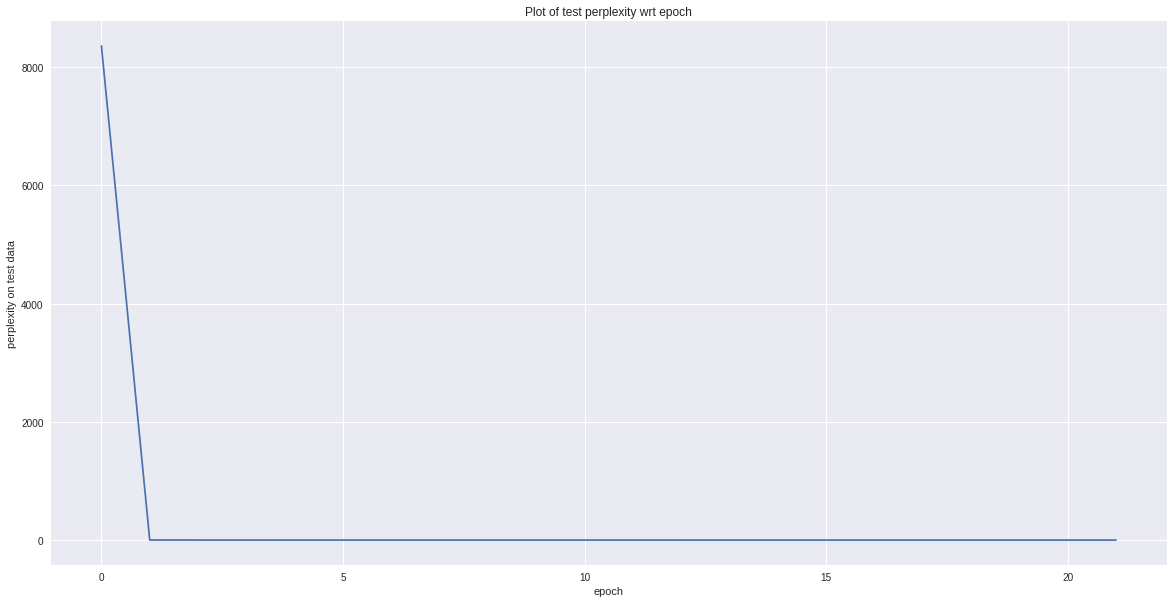

In [0]:
logs = pt_util.read_log(LOG_PATH)
logs = np.array(logs)
print (logs)
train_loss = [x[1] for x in logs[0]]
test_loss = [x[1] for x in logs[1]]
test_accuracy = [x[1] for x in logs[2]]

pt_util.plot(np.arange(len(train_loss)), train_loss, "Plot of training loss wrt epoch", "epoch", "loss on training data")
pt_util.plot(np.arange(len(test_loss)), test_loss, "Plot of test loss wrt epoch", "epoch", "loss on test data")
pt_util.plot(np.arange(len(test_accuracy)), test_accuracy, "Plot of test accuracy wrt epoch", "epoch", "accuracy on test data")

pt_util.plot(np.arange(len(train_loss)), np.exp(train_loss), "Plot of training perplexity wrt epoch", "epoch", "perplexity on training data")
pt_util.plot(np.arange(len(test_loss)), np.exp(test_loss), "Plot of test perplexity wrt epoch", "epoch", "perplexity on test data")

#Part 8: Other things
Choose **two** of the following to try. It will probably be beneficial to create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
2. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
3. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
4. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
5. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called homework2_python.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

2. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
3. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

4. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
5. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

#NEW CORPUS

# Part 1: Preprocessing the data

In [0]:
import re
import math
import glob
def prepare_data(file):
    with open(file) as f:
            # This reads all the data from the file, but does not do any processing on it.
          data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub('\s+', ' ', data).strip()

    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    count = 0
    list_indexed = []
    for char in data:
        if char not in voc2ind.keys():
            voc2ind[char] = count
            count += 1
        list_indexed.append(voc2ind[char])
        #pass # TODO Fill this in
    print (len(voc2ind.keys()))
    
    ind2voc = {val: key for key, val in voc2ind.items()}
    
    data_indexed = np.array(list_indexed)
    list_indexed = []
    print (data_indexed.shape)
    print (data_indexed.shape[0])
    
    split_index = math.ceil((4 * data_indexed.shape[0]) / 5)
    print (split_index)
    train_text = data_indexed[:split_index] 
    # TODO Fill this in
    test_text = data_indexed[split_index:]
    # TODO Fill this in
    
    print (train_text.shape, test_text.shape)
    
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'wikitext_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'wikitext_chars_test.pkl', 'wb'))
    
    return voc2ind
    
voc2ind = prepare_data(DATA_PATH + '/wikitext/' + 'wiki.train.raw')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

1012
(10845406,)
10845406
8676325
(8676325,) (2169081,)


# Part 2: Loading the data

In [0]:
class WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(WikiTextDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        num = dataset['tokens'].shape[0] - (dataset['tokens'].shape[0] % batch_size)
        self.dataset = dataset['tokens'][:num]
        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        chunk_size = math.floor(self.dataset.shape[0] / self.batch_size)
        num_examples_batch = math.floor(chunk_size / self.sequence_length)
        length = self.batch_size * num_examples_batch 
        return length
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_size = math.floor(self.dataset.shape[0] / self.batch_size)
        within_chunk, chunk_idx = divmod(idx, self.batch_size)
        new_idx = chunk_idx * chunk_size + within_chunk * self.sequence_length
        last_idx = new_idx + self.sequence_length - 1
        data = self.dataset[new_idx:last_idx+2]
        data = torch.LongTensor(data)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 3: Defining the Network

In [0]:
TEMPERATURE = 0.5

class WikiTextNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(WikiTextNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        x = x.view(-1,1)
        x = self.encoder(x)
        x = x.view(batch_size, sequence_length, self.feature_size)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Part 4: Character Generation

In [0]:
BEAM_WIDTH = 20


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, temperature=0.5)

        outputs = []
        # Initializes the beam list
        beam = [([], output, hidden, 0)]
        for ii in range(sequence_length):
            if sampling_strategy == 'max':
                # TODO max sampling strategy
                # raise NotImplementedError
                _, pred_label = torch.max(output, 1)
                outputs.append(pred_label)
                new_input = pred_label.unsqueeze(1)
                output, hidden = model.inference(new_input, hidden, temperature=0.5)
                
            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                # raise NotImplementedError 
                pred_label = torch.multinomial(output, 1, True)
                outputs.append(pred_label)
                new_input = pred_label.unsqueeze(1)
                output, hidden = model.inference(new_input, hidden, temperature=0.5)
                

            elif sampling_strategy == 'beam':
                # Todo: beam search sampling strategy
                # raise NotImplementedError
                new_beam = []
                for be in beam:
                    pred_label = torch.multinomial(be[1], 2, True)
                    for p in pred_label[0]:
                        out1, hid1 = model.inference(p, be[2], temperature=0.5)
                        new_beam.append((be[0]+[p], out1, hid1, be[3]+np.log(be[1][0][p].item())))
                new_beam = sorted(new_beam, key=lambda x: x[3], reverse=True)[:beam_width]
                beam = new_beam
        
        if sampling_strategy == 'beam':
            outputs = beam[0][0]
        
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 5: Training

In [0]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 200
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs_corpus/log.pkl'

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


data_train = WikiTextDataset(DATA_PATH + 'wikitext_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = WikiTextDataset(DATA_PATH + 'wikitext_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = WikiTextNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_corpus')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_corpus/%03d.pt' % epoch)
        seed_words = 'Music and Art'
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints_corpus/%03d.pt' % epoch, 0)


Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([1012, 512]) = 2MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l1 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l1 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([1012, 512]) = 2MB
decoder.bias -> 	torch.Size([1012]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints_corpus/003.pt
enumerate test    84
Input	totype on August 16 , 2007 . The standard edition for Windows was released on July 25 , 2008 , conta
GT	otype on August 16 , 2007 . The standard edition for Windows was released on July 25 , 2008 , contai
pred	hrh e ,f tugust 19 , t000 , The seatdird oluteon oor titgsm  ,es seleas

# Part 6: Experiments


In [0]:
seed_words = 'The champion'
sequence_length = 200

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

generated with max	 The champion in the season of the second season . The second season was a second season , and the state of the second season , the state of the second season , the state of the second season , the state of the se
generated with sample	 The championed the Chinese designation with a marchine to House S. ( 200 – 1 ) , on 18 , 2003 , which set he stood a most of the contract player to the Hide God . The state of the season was a new season , in the
generated with sample	 The champions , a head of 4 @.@ 0 m ( 1 @.@ 9 % ) . The best serves in the Australia was the ball of the their twat the United States and experience in the 2008 season . The Australian passes had been a second @-
generated with sample	 The championed back and a concert of up in the series of the early 1920 children and a transle was a match in which the first series was contemporarely designed to returned the second season . The State of the ar
generated with sample	 The champions in several parts carri

# WORD RNN

# Part 1: Preprocessing the data

In [112]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [119]:
## Without PUNCTUATION
from nltk.tokenize import sent_tokenize, word_tokenize 
import re
import math
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub('\s+', ' ', data).strip()
    
    voc2ind = {}
    # Compute voc2ind and transform the data into an integer representation of the tokens.
   
    word_count = {}
    # word tokenization
    data = word_tokenize(data)
    
    #filtering out punctuation
    data = [word.lower() for word in data if word.isalpha()]
    print (len(data))
    for word in data:
        if word not in word_count.keys():
            word_count[word] = 1
        else:
            word_count[word] += 1
        #pass # TODO Fill this in
    print (len(word_count.keys()))
    
    subs_words = []
    for key, val in word_count.items():
        if val < 5:
            subs_words.append(key)
    print (len(subs_words))
    
    replace_count = 0
    for (i, word) in enumerate(data):
        if word in subs_words:
            data[i] = "<unknown>"
            replace_count += 1
    print ("No of words getting substituted = ", replace_count)
    
    count = 0       
    for word in data:
        if word not in voc2ind.keys():
            voc2ind[word] = count
            count += 1
    voc2ind[' '] = count
    
    print (len(voc2ind.keys()))
            
    ind2voc = {val: key for key, val in voc2ind.items()}
    
    
    list_indexed = []
    for w in data:
        list_indexed.append(voc2ind[w])
        list_indexed.append(voc2ind[' '])
    
    data = []
    split_index = math.ceil((4 * len(list_indexed) / 5))
    print (split_index)
    
    word_indexed = np.array(list_indexed)
    list_indexed = []
    
    train_text = word_indexed[:split_index] 
    # TODO Fill this in
    test_text = word_indexed[split_index:]
    # TODO Fill this in
    
    print (train_text.shape, test_text.shape)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_word_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_word_test.pkl', 'wb'))
    
    return voc2ind
    
voc2ind = prepare_data(DATA_PATH + 'harry_potter.txt')


1075965
21416
12592
No of words getting substituted =  22106
8826
1721544
(1721544,) (430386,)


In [159]:
## With PUNCTUATION
from nltk.tokenize import sent_tokenize, word_tokenize 
import re
import math
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub('\s+', ' ', data).strip()
    
    voc2ind = {}
    # Compute voc2ind and transform the data into an integer representation of the tokens.
   
    word_count = {}
    # word tokenization
    data = word_tokenize(data)
    
    data = [word.lower() for word in data]
    print (len(data))
    for word in data:
        if word not in word_count.keys():
            word_count[word] = 1
        else:
            word_count[word] += 1
        #pass # TODO Fill this in
    print (len(word_count.keys()))
    
    subs_words = []
    for key, val in word_count.items():
        if val < 5:
            subs_words.append(key)
    print (len(subs_words))
    
    replace_count = 0
    for (i, word) in enumerate(data):
        if word in subs_words:
            data[i] = "<unknown>"
            replace_count += 1
    print ("No of words getting substituted = ", replace_count)
    
    count = 0       
    for word in data:
        if word not in voc2ind.keys():
            voc2ind[word] = count
            count += 1
    voc2ind[' '] = count
    
    print (len(voc2ind.keys()))
            
    ind2voc = {val: key for key, val in voc2ind.items()}
    
    
    list_indexed = []
    for w in data:
        list_indexed.append(voc2ind[w])
        list_indexed.append(voc2ind[' '])
    
    data = []
    split_index = math.ceil((4 * len(list_indexed) / 5))
    print (split_index)
    
    word_indexed = np.array(list_indexed)
    list_indexed = []
    
    train_text = word_indexed[:split_index] 
    # TODO Fill this in
    test_text = word_indexed[split_index:]
    # TODO Fill this in
    
    print (train_text.shape, test_text.shape)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_wordpunct_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_wordpunct_test.pkl', 'wb'))
    
    return voc2ind
    
voc2ind = prepare_data(DATA_PATH + 'harry_potter.txt')


1379989
25175
16106
No of words getting substituted =  26657
9071
2207983
(2207983,) (551995,)


In [0]:
class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word.lower()] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Part 2: Loading the data

In [0]:
class HarryPotterWordDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterWordDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        num = len(dataset['tokens']) - (len(dataset['tokens']) % batch_size)
        self.dataset = dataset['tokens'][:num]
        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        chunk_size = math.floor(len(self.dataset) / self.batch_size)
        num_examples_batch = math.floor(chunk_size / self.sequence_length)
        length = self.batch_size * num_examples_batch
        return length
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_size = math.floor(len(self.dataset) / self.batch_size)
        within_chunk, chunk_idx = divmod(idx, self.batch_size)
        new_idx = chunk_idx * chunk_size + within_chunk * self.sequence_length
        last_idx = new_idx + self.sequence_length - 1
        data = self.dataset[new_idx:last_idx+2]
        data = torch.LongTensor(data)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 3: Defining the Network


In [0]:
TEMPERATURE = 1

class HarryPotterWordNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterWordNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        x = x.view(-1,1)
        x = self.encoder(x)
        x = x.view(batch_size, sequence_length, self.feature_size)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

      
    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Part 4: Word Generation

In [0]:
BEAM_WIDTH = 20


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, temperature=1)

        outputs = []
        # Initializes the beam list
        beam = [([], output, hidden, 0)]
        for ii in range(sequence_length):
            if sampling_strategy == 'max':
                # TODO max sampling strategy
                # raise NotImplementedError
                _, pred_label = torch.max(output, 1)
                outputs.append(pred_label)
                new_input = pred_label.unsqueeze(1)
                output, hidden = model.inference(new_input, hidden, temperature=1)
                
            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                # raise NotImplementedError 
                pred_label = torch.multinomial(output, 1, True)
                outputs.append(pred_label)
                new_input = pred_label.unsqueeze(1)
                output, hidden = model.inference(new_input, hidden, temperature=1)
                

            elif sampling_strategy == 'beam':
                # Todo: beam search sampling strategy
                # raise NotImplementedError
                new_beam = []
                for be in beam:
                    pred_label = torch.multinomial(be[1], 2, True)
                    for p in pred_label[0]:
                        out1, hid1 = model.inference(p, be[2], temperature=1)
                        new_beam.append((be[0]+[p], out1, hid1, be[3]+np.log(be[1][0][p].item())))
                new_beam = sorted(new_beam, key=lambda x: x[3], reverse=True)[:beam_width]
                beam = new_beam
        
        if sampling_strategy == 'beam':
            outputs = beam[0][0]
        
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 5: Training

In [166]:
## With PUNCTUATION
SEQUENCE_LENGTH = 30
BATCH_SIZE = 128
FEATURE_SIZE = 1024
TEST_BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs_wordss_punct/log.pkl'

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_wordpunct_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_wordpunct_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterWordNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_wordss_punct')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_wordss_punct/%03d.pt' % epoch)
        seed_words = 'Harry Potter '
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 30, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 30, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints_wordss_punct/%03d.pt' % epoch, 0)


Using device cuda
num workers: 2
Restoring:
Shape mismatch for var encoder.weight expected torch.Size([9071, 1024]) got torch.Size([9071, 512])
Shape mismatch for var gru.weight_ih_l0 expected torch.Size([3072, 1024]) got torch.Size([1536, 512])
Shape mismatch for var gru.weight_hh_l0 expected torch.Size([3072, 1024]) got torch.Size([1536, 512])
Shape mismatch for var gru.bias_ih_l0 expected torch.Size([3072]) got torch.Size([1536])
Shape mismatch for var gru.bias_hh_l0 expected torch.Size([3072]) got torch.Size([1536])
Shape mismatch for var gru.weight_ih_l1 expected torch.Size([3072, 1024]) got torch.Size([1536, 512])
Shape mismatch for var gru.weight_hh_l1 expected torch.Size([3072, 1024]) got torch.Size([1536, 512])
Shape mismatch for var gru.bias_ih_l1 expected torch.Size([3072]) got torch.Size([1536])
Shape mismatch for var gru.bias_hh_l1 expected torch.Size([3072]) got torch.Size([1536])
Shape mismatch for var decoder.weight expected torch.Size([9071, 1024]) got torch.Size([9071

In [136]:
## Without PUNCTUATION
SEQUENCE_LENGTH = 30
BATCH_SIZE = 128
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs_wordss/log.pkl'

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_word_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_word_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterWordNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_wordss')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_wordss/%03d.pt' % epoch)
        seed_words = 'Harry Potter '
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 30, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 30, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints_wordss/%03d.pt' % epoch, 0)


Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([8826, 512]) = 18MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l1 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l1 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([8826, 512]) = 18MB
decoder.bias -> 	torch.Size([8826]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints_wordss/013.pt
enumerate test    112
Input	harry helped dumbledore back into the icy <unknown> that filled the <unknown> in the cliff 
GT	 helped dumbledore back into the icy <unknown> that filled the <unknown> in the cliff it
pred	 and the and to the room table and he the <unknown> and the world and


Input	salt the se

# Part 6: Experiments

In [178]:
## With PUNCTUATION
seed_words = 'harry and ron'
sequence_length = 50

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

generated with max	 harry and ron . '' `` i 'm going to be a <unknown> , '' said harry , `` i 'm not going to be a <unknown> .
generated with sample	 harry and ron . '' fred weasley had seen , but he did i have talked to me anything , but he cleared his head , and then
generated with sample	 harry and ron will `` but she would have to under this game ! '' the portrait hand sounded . but <unknown> , professor . ... `` i
generated with sample	 harry and ron <unknown> every large . there ! get deserves into excitement , below <unknown> will be visiting on and <unknown> anything . ... maybe it was
generated with sample	 harry and ron now . and then , and lay . . . . . `` nightfall ? '' said harry , . he went from a bag
generated with sample	 harry and ron . . . . . <unknown> lord . harry might have dad put to remain into his intend once at the other so i 'm
generated with sample	 harry and ron bang . she turned her hair to live her son , yet hermione was not care of ravenclaw 's present . 

In [157]:
## Without PUNCTUATION
seed_words = 'harry and ron'
sequence_length = 40

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

generated with max	 harry and ron harry said harry and hermione and hermione were still <unknown> and they were still <unknown> and they were still <unknown>
generated with sample	 harry and ron he killed harry i would want to this he told me harry come back at neville bed he <unknown> to
generated with sample	 harry and ron with harry potter she walked splintered silencio his face as lockhart completely opened the book he felt like the <unknown>
generated with sample	 harry and ron shot harry said smiling at once and eerily loves was shafts that remembering harry never turned late in every two
generated with sample	 harry and ron all if harry school by those here you without joke and looking at hermione who had put his natural of
generated with sample	 harry and ron feel he finished i can months for us some because he seized his friends off he took the crowd of
generated with sample	 harry and ron an apparated work on his own comment yes though they loads into an easier yeh have to mc